In [23]:
# Part 0: Setup & inputs

from dataclasses import dataclass
from typing import Optional, Tuple
import copy
import numpy as np
import pandas as pd

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

# === User inputs (edit these) ===
SOLAR_CSV_PATH = "data/day_ahead_15min_MW.csv"   # path to your 15-min solar CSV
TS_COL = "timestamp"                  # timestamp column, aligned to :00/:15/:30/:45
SOLAR_MW_COL = "expected_power_kw"            # solar power in MW

# Money & base energy per 15-min block (kWh); replace with vectors if you have time-varying plans
FIT_RATE_PER_KWH = 2.0               # currency per kWh (example)
CONTRACT_KWH_15MIN = 45.0*0.6*1000           # e.g., 1 MW * 0.25h * 1000 = 250 kWh
EGAT_PLAN_KWH_15MIN = 45.0*1000
HAS_EGAT_PLAN_IN_WIN3 = False        # Window 3 uses EGAT plan if True; else Contract

# BESS parameters
BESS_ENABLED = True
BESS_CFG = dict(
    capacity_mwh=20.0,
    soc_init_mwh=10.0,
    p_discharge_max_mw=10.0,
    p_charge_max_mw=10.0,
    eta_discharge=0.95,
    eta_charge=0.95,
    ramp_mw_per_min=None,  # set to a number if you want ramp limit
)

# Hydro parameters
HYDRO_ENABLED = True
LOOKAHEAD_BLOCKS_FOR_HYDRO = 96  # simple horizon (1 hour) for start decision

from src.models.FEB_turbine_unit_U1 import TurbineUnitConfig, make_unit  # hydro model (U1)  # [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_turbine_unit_U1.py)
hydro_config = TurbineUnitConfig(
    min_mw=7.0,
    max_mw=12.0,
    ramp_mw_per_min=1.0,
    startup_time_min=3.0,
    shutdown_time_min=5.0,
    startup_cost=1000.0,
)

In [25]:
# Part 1: Revenue functions (your exact logic for windows, caps, 12% penalty, 14/15 adjustments)

from objective_function import (
    compute_revenue_rows,
    detect_time_window_for_aligned_blocks,
)

# compute_revenue_rows(...) applies:
#  - Window base selection (Contract/EGAT/Window 3 rule)
#  - Cap at base
#  - 12% penalty on shortfall
#  - 14/15 adjustment for blocks starting at 06:00, 16:00, 18:00 (aligned timestamps)
# See your objective_function.py for full details.  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)

In [27]:
# Part 2: A minimal standalone BESS consistent with your FEB_bess.py behavior
# Sign convention: +MW = discharge to grid, -MW = charge from grid.
# Enforces power, SOC, efficiencies and optional ramp.

@dataclass
class BESSConfig:
    capacity_mwh: float
    soc_init_mwh: float
    p_discharge_max_mw: float
    p_charge_max_mw: float
    eta_discharge: float = 0.95
    eta_charge: float = 0.95
    ramp_mw_per_min: Optional[float] = None

class SimpleBESS:
    def __init__(self, cfg: BESSConfig):
        self.cfg = cfg
        self.soc_mwh = float(cfg.soc_init_mwh)
        self.current_power_mw = 0.0
        self._cmd_power_mw = 0.0
        self._ramp_mw_per_s = (cfg.ramp_mw_per_min / 60.0) if cfg.ramp_mw_per_min else None

    def command_power(self, power_mw: float):
        self._cmd_power_mw = float(power_mw)

    def step(self, dt_min: float) -> float:
        dt_s = dt_min * 60.0
        dt_h = dt_min / 60.0

        # ramp
        target = self._cmd_power_mw
        if self._ramp_mw_per_s is not None:
            max_delta = self._ramp_mw_per_s * dt_s
            target = max(min(target, self.current_power_mw + max_delta),
                         self.current_power_mw - max_delta)

        # power limits
        if target >= 0:
            target = min(target, self.cfg.p_discharge_max_mw)
        else:
            target = max(target, -self.cfg.p_charge_max_mw)

        # SOC constraints and efficiency
        if target >= 0:  # discharge
            energy_needed_mwh = (target / self.cfg.eta_discharge) * dt_h
            if energy_needed_mwh > self.soc_mwh + 1e-12:
                # limit by SOC (average over interval)
                target = (self.soc_mwh / dt_h) * self.cfg.eta_discharge if dt_h > 0 else 0.0
                energy_needed_mwh = (target / self.cfg.eta_discharge) * dt_h
            self.soc_mwh -= energy_needed_mwh
        else:           # charge
            charge_power = -target
            energy_in_mwh = (charge_power * self.cfg.eta_charge) * dt_h
            if self.soc_mwh + energy_in_mwh > self.cfg.capacity_mwh + 1e-12:
                energy_room = self.cfg.capacity_mwh - self.soc_mwh
                charge_power = (energy_room / (self.cfg.eta_charge * dt_h)) if dt_h > 0 else 0.0
                target = -charge_power
                energy_in_mwh = (charge_power * self.cfg.eta_charge) * dt_h
            self.soc_mwh += energy_in_mwh

        self.current_power_mw = float(target)
        return self.current_power_mw

# NOTE:
# If you want to use your original FEB_bess.BESS class, you can import it instead,
# but it requires the 'base' module. This standalone mirrors the same sign and constraints.  # [3](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_bess.py)

In [29]:
# Part 3: Window-based base computation using your detection function

def compute_base_kwh_for_block(ts: pd.Timestamp,
                               contract_kwh: float,
                               egat_plan_kwh: float,
                               has_egat_plan_in_win3: bool) -> Tuple[float, bool]:
    """
    Returns (base_kwh_for_window, adjusted_block_flag)
    - Window 1 -> Contract
    - Window 2 -> EGAT plan
    - Window 3 -> EGAT plan if has_egat_plan_in_win3 else Contract
    'adjusted_block_flag' is True for 06:00, 16:00, 18:00 blocks (14/15 revenue count).  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
    """
    win_id, adjusted = detect_time_window_for_aligned_blocks(ts.to_pydatetime())  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
    if win_id == 1:
        base = contract_kwh
    elif win_id == 2:
        base = egat_plan_kwh
    else:
        base = egat_plan_kwh if has_egat_plan_in_win3 else contract_kwh
    return base, adjusted


def attach_static_bases(df: pd.DataFrame,
                        contract_kwh_15min: float,
                        egat_plan_kwh_15min: float,
                        has_egat_plan_in_win3: bool) -> pd.DataFrame:
    """
    Attach base columns (constant per block). Replace with time-varying columns if available.  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
    """
    out = df.copy()
    out["contract_kwh"] = float(contract_kwh_15min)
    out["egat_plan_kwh"] = float(egat_plan_kwh_15min)
    out["has_egat_plan_in_win3"] = bool(has_egat_plan_in_win3)
    return out

In [31]:
# Part 4: Dispatch & revenue
from math import isfinite

def optimize_three_asset_day(
    solar_csv_path: str,
    ts_col: str,
    solar_mw_col: str,
    fit_rate_per_kwh: float,
    contract_kwh_15min: float,
    egat_plan_kwh_15min: float,
    has_egat_plan_in_win3: bool,
    use_bess: bool,
    bess_cfg: Optional[dict],
    use_hydro: bool,
    hydro_cfg: Optional[TurbineUnitConfig],
    lookahead_blocks_for_hydro: int,
):
    # Load solar
    df = pd.read_csv(solar_csv_path)
    df[ts_col] = pd.to_datetime(df[ts_col])
    df = df.sort_values(ts_col).reset_index(drop=True)

    # Gentle alignment check (optional)
    if not all(df[ts_col].dt.minute.isin([0, 15, 30, 45])):
        raise ValueError("Timestamps must be aligned to :00/:15/:30/:45 for correct 14/15 adjustments.")

    # Attach base columns and FiT
    df = attach_static_bases(df, contract_kwh_15min, egat_plan_kwh_15min, has_egat_plan_in_win3)  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
    df["fit_rate"] = float(fit_rate_per_kwh)

    # Assets
    bess = SimpleBESS(BESSConfig(**bess_cfg)) if (use_bess and bess_cfg) else None
    unit = make_unit(hydro_cfg) if use_hydro else None  # U1 unit instance  # [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_turbine_unit_U1.py)

    # Time step & conversions
    dt_min = 15.0
    kwh_per_mw_block = 1000.0 * (dt_min / 60.0)  # 250.0

    # Value of 1 kWh when you're short: payable + penalty avoidance ≈ 1.12 * FiT.  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
    kwh_value_when_short = 1.12 * fit_rate_per_kwh

    def should_start_hydro(idx, bess_state_copy) -> bool:
        # Start only if currently shut down and expected recovered shortfall value >= startup cost
        if (unit is None) or (lookahead_blocks_for_hydro <= 0) or (unit.state.name != "SHUTDOWN"):
            return False

        horizon = min(len(df) - idx, lookahead_blocks_for_hydro)
        recov_kwh = 0.0

        min_mw = (hydro_cfg.min_mw if hydro_cfg else TurbineUnitConfig().min_mw)
        min_kwh_per_block = min_mw * kwh_per_mw_block

        sim_soc = bess_state_copy.soc_mwh if bess_state_copy else None

        for j in range(horizon):
            ts = df.loc[idx + j, ts_col]
            solar_mw = float(df.loc[idx + j, solar_mw_col])
            base_kwh, adjusted = compute_base_kwh_for_block(
                ts,
                df.loc[idx + j, "contract_kwh"],
                df.loc[idx + j, "egat_plan_kwh"],
                df.loc[idx + j, "has_egat_plan_in_win3"],
            )
            sched_base_kwh = base_kwh * (15.0 / 14.0) if adjusted else base_kwh  # avoid 14/15 shortfall  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
            e_solar_kwh = max(solar_mw, 0.0) * kwh_per_mw_block
            e_def_kwh = max(sched_base_kwh - e_solar_kwh, 0.0)

            if bess_state_copy and e_def_kwh > 0:
                p_dis_max = bess_state_copy.cfg.p_discharge_max_mw
                max_kwh_power = p_dis_max * kwh_per_mw_block
                soc_kwh_available = (sim_soc * bess_state_copy.cfg.eta_discharge) * 1000.0
                e_bess_kwh = min(e_def_kwh, max_kwh_power, soc_kwh_available)
                e_from_soc_mwh = (e_bess_kwh / 1000.0) / bess_state_copy.cfg.eta_discharge
                sim_soc = max(sim_soc - e_from_soc_mwh, 0.0)
                e_def_kwh = max(e_def_kwh - e_bess_kwh, 0.0)

            valuable_kwh = min(e_def_kwh, min_kwh_per_block)
            recov_kwh += valuable_kwh

        startup_cost = (hydro_cfg.startup_cost if hydro_cfg else TurbineUnitConfig().startup_cost)
        expected_value = recov_kwh * kwh_value_when_short
        return expected_value >= startup_cost

    # Main loop
    rows = []
    for i, r in df.iterrows():
        ts = r[ts_col]
        solar_mw = float(r[solar_mw_col])

        base_kwh, adjusted = compute_base_kwh_for_block(
            ts, r["contract_kwh"], r["egat_plan_kwh"], r["has_egat_plan_in_win3"]
        )
        # In adjusted blocks (06:00/16:00/18:00) revenue counts 14/15 -> aim for base*(15/14) delivered.  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
        sched_base_kwh = base_kwh * (15.0 / 14.0) if adjusted else base_kwh

        e_solar_kwh = max(solar_mw, 0.0) * kwh_per_mw_block

        # BESS command
        bess_cmd_mw = 0.0
        if bess is not None:
            if e_solar_kwh > sched_base_kwh:
                surplus_kwh = e_solar_kwh - sched_base_kwh
                max_charge_kwh = bess.cfg.p_charge_max_mw * kwh_per_mw_block
                charge_kwh = min(surplus_kwh, max_charge_kwh)
                room_kwh = (bess.cfg.capacity_mwh - bess.soc_mwh) * bess.cfg.eta_charge * 1000.0
                charge_kwh = max(0.0, min(charge_kwh, room_kwh))
                bess_cmd_mw = -(charge_kwh / kwh_per_mw_block)
            else:
                deficit_kwh = max(sched_base_kwh - e_solar_kwh, 0.0)
                max_dis_kwh = bess.cfg.p_discharge_max_mw * kwh_per_mw_block
                soc_kwh = (bess.soc_mwh * bess.cfg.eta_discharge) * 1000.0
                dis_kwh = min(deficit_kwh, max_dis_kwh, soc_kwh)
                bess_cmd_mw = (dis_kwh / kwh_per_mw_block)

        # Hydro command
        if unit is not None:
            # Estimate remaining deficit after BESS plan (pre-step approximation)
            e_bess_pre_kwh = (abs(bess_cmd_mw) * kwh_per_mw_block) if bess is not None else 0.0
            e_after_bess_kwh = e_solar_kwh + (e_bess_pre_kwh if bess_cmd_mw >= 0 else -e_bess_pre_kwh)
            rem_def_kwh = max(sched_base_kwh - e_after_bess_kwh, 0.0)

            if rem_def_kwh > 1e-6 and unit.state.name == "SHUTDOWN":
                bess_copy = copy.deepcopy(bess) if bess is not None else None
                if should_start_hydro(i, bess_copy):
                    unit.request_output(unit.config.min_mw)
                else:
                    unit.request_output(0.0)
            else:
                if rem_def_kwh > 1e-6:
                    need_mw = rem_def_kwh / kwh_per_mw_block
                    tgt_mw = min(max(need_mw, unit.config.min_mw), unit.config.max_mw)
                    unit.request_output(tgt_mw)
                else:
                    unit.request_output(0.0)

        # Execute steps for the 15-min block
        p_bess_mw = 0.0
        if bess is not None:
            bess.command_power(bess_cmd_mw)
            p_bess_mw = bess.step(dt_min)

        p_hydro_mw = unit.step(dt_min) if unit is not None else 0.0

        # Metered energy (kWh) to grid
        e_read_kwh = (max(solar_mw, 0.0) + p_bess_mw + p_hydro_mw) * kwh_per_mw_block
        e_read_kwh = max(0.0, e_read_kwh)

        rows.append({
            "ts_start": ts,
            "solar_mw": solar_mw,
            "p_bess_mw": p_bess_mw if bess is not None else 0.0,
            "soc_mwh": bess.soc_mwh if bess is not None else np.nan,
            "p_hydro_mw": p_hydro_mw if unit is not None else 0.0,
            "hydro_state": (unit.state.name if unit is not None else "NA"),
            "e_read_kwh": e_read_kwh,
            "fit_rate": r["fit_rate"],
            "contract_kwh": r["contract_kwh"],
            "egat_plan_kwh": r["egat_plan_kwh"],
            "has_egat_plan_in_win3": r["has_egat_plan_in_win3"],
        })

    sched_df = pd.DataFrame(rows)

    # Compute revenue using your exact function (caps, 12% penalty, 14/15 adjustments).  # [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
    pay_df_input = sched_df[[
        "ts_start", "e_read_kwh", "fit_rate", "contract_kwh", "egat_plan_kwh", "has_egat_plan_in_win3"
    ]].copy()
    revenue_df = compute_revenue_rows(pay_df_input)

    # Merge revenue fields back (drop duplicated cols from revenue_df)
    merge_cols_drop = ["ts_start", "e_read_kwh", "fit_rate", "contract_kwh", "egat_plan_kwh", "has_egat_plan_in_win3"]
    revenue_df = pd.concat([sched_df.reset_index(drop=True),
                            revenue_df.drop(columns=merge_cols_drop)], axis=1)

    total_revenue = revenue_df["payment_currency"].sum()
    return sched_df, revenue_df, total_revenue

In [33]:
# Part 5: Run

_sched_df, _rev_df, _total = optimize_three_asset_day(
    solar_csv_path=SOLAR_CSV_PATH,
    ts_col=TS_COL,
    solar_mw_col=SOLAR_MW_COL,
    fit_rate_per_kwh=FIT_RATE_PER_KWH,
    contract_kwh_15min=CONTRACT_KWH_15MIN,
    egat_plan_kwh_15min=EGAT_PLAN_KWH_15MIN,
    has_egat_plan_in_win3=HAS_EGAT_PLAN_IN_WIN3,
    use_bess=BESS_ENABLED,
    bess_cfg=BESS_CFG if BESS_ENABLED else None,
    use_hydro=HYDRO_ENABLED,
    hydro_cfg=hydro_config if HYDRO_ENABLED else None,
    lookahead_blocks_for_hydro=LOOKAHEAD_BLOCKS_FOR_HYDRO,
)

print(f"Total revenue: {_total:,.2f}")
display(_rev_df.head(10))

Total revenue: 871,160.74


,ts_start,solar_mw,p_bess_mw,soc_mwh,p_hydro_mw,hydro_state,e_read_kwh,fit_rate,contract_kwh,egat_plan_kwh,has_egat_plan_in_win3,window_id,adjusted_subinterval,e_use_kwh,base_kwh,payable_kwh,shortfall_kwh,penalty_currency,payment_currency
0,2026-01-03 00:00:00,0.0,10.0,7.368421,0.0,RAMP_UP,2500.0,2.0,27000.0,45000.0,False,2,False,2500.0,45000.0,2500.0,42500.0,10200.0,-5200.0
1,2026-01-03 00:15:00,0.0,10.0,4.736842,12.0,RAMP_UP,5500.0,2.0,27000.0,45000.0,False,2,False,5500.0,45000.0,5500.0,39500.0,9480.0,1520.0
2,2026-01-03 00:30:00,0.0,10.0,2.105263,12.0,NORMAL,5500.0,2.0,27000.0,45000.0,False,2,False,5500.0,45000.0,5500.0,39500.0,9480.0,1520.0
3,2026-01-03 00:45:00,0.0,8.0,0.000000,12.0,NORMAL,5000.0,2.0,27000.0,45000.0,False,2,False,5000.0,45000.0,5000.0,40000.0,9600.0,400.0
4,2026-01-03 01:00:00,0.0,0.0,0.000000,12.0,NORMAL,3000.0,2.0,27000.0,45000.0,False,2,False,3000.0,45000.0,3000.0,42000.0,10080.0,-4080.0
5,2026-01-03 01:15:00,0.0,0.0,0.000000,12.0,NORMAL,3000.0,2.0,27000.0,45000.0,False,2,False,3000.0,45000.0,3000.0,42000.0,10080.0,-4080.0
6,2026-01-03 01:30:00,0.0,0.0,0.000000,12.0,NORMAL,3000.0,2.0,27000.0,45000.0,False,2,False,3000.0,45000.0,3000.0,42000.0,10080.0,-4080.0
7,2026-01-03 01:45:00,0.0,0.0,0.000000,12.0,NORMAL,3000.0,2.0,27000.0,45000.0,False,2,False,3000.0,45000.0,3000.0,42000.0,10080.0,-4080.0
8,2026-01-03 02:00:00,0.0,0.0,0.000000,12.0,NORMAL,3000.0,2.0,27000.0,45000.0,False,2,False,3000.0,45000.0,3000.0,42000.0,10080.0,-4080.0
9,2026-01-03 02:15:00,0.0,0.0,0.000000,12.0,NORMAL,3000.0,2.0,27000.0,45000.0,False,2,False,3000.0,45000.0,3000.0,42000.0,10080.0,-4080.0


In [37]:
import matplotlib.pyplot as plt

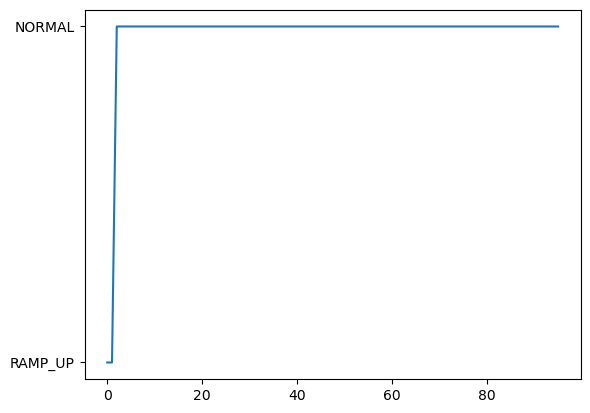

In [39]:
plt.plot(_rev_df['hydro_state'])

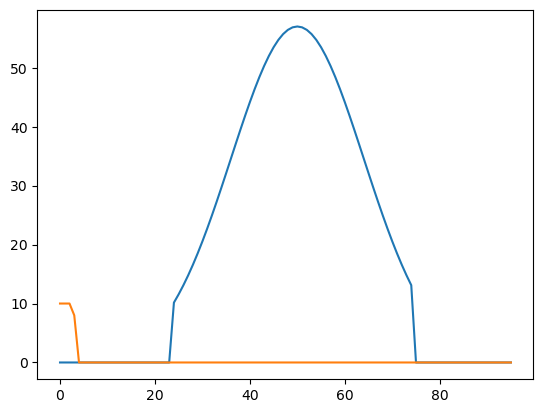

In [41]:
plt.plot(_rev_df['solar_mw'])
plt.plot(_rev_df['p_bess_mw'])

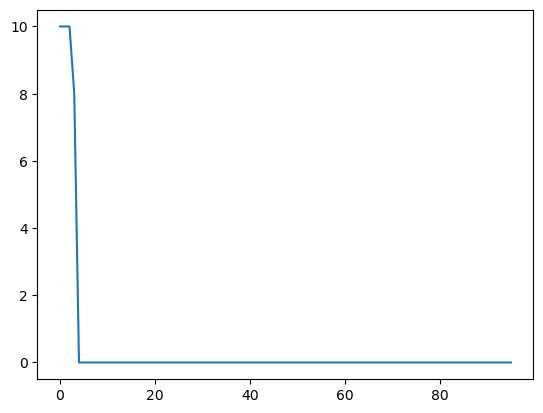

In [43]:
plt.plot(_rev_df['p_bess_mw'])

In [46]:
# Cell A: Imports & color palette for consistency

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Nice readable style
plt.style.use("seaborn-v0_8-whitegrid")

COLORS = {
    "solar": "#d4a017",        # goldenrod
    "bess":  "#2ca02c",        # green
    "hydro": "#1f77b4",        # blue
    "base":  "#7f7f7f",        # gray
    "short": "#d62728",        # red
    "pay":   "#6a51a3",        # purple
    "pen":   "#e377c2",        # pink
    "cum":   "#9467bd",        # purple (darker)
}

In [48]:
# Cell B: Helpers to visually annotate windows & special adjusted blocks (14/15)

def shade_windows(ax, df, ts_col="ts_start", window_col="window_id"):
    """
    Adds subtle background shading by window_id:
      - Window 1: very light yellow
      - Window 2: very light cyan
      - Window 3: very light orange
    """
    window_colors = {
        1: (1.0, 0.95, 0.75, 0.2),  # pale yellow
        2: (0.75, 0.95, 1.0, 0.2),  # pale cyan
        3: (1.0, 0.9, 0.8, 0.25),   # pale orange
    }
    # Find contiguous segments by window
    seg_start = 0
    w_prev = int(df.iloc[0][window_col])
    for i in range(1, len(df)):
        w_now = int(df.iloc[i][window_col])
        if w_now != w_prev:
            x0 = df.iloc[seg_start][ts_col]
            x1 = df.iloc[i-1][ts_col]
            ax.axvspan(x0, x1, color=window_colors.get(w_prev, (0.9, 0.9, 0.9, 0.15)), linewidth=0)
            seg_start = i
            w_prev = w_now
    # last segment
    x0 = df.iloc[seg_start][ts_col]
    x1 = df.iloc[len(df)-1][ts_col]
    ax.axvspan(x0, x1, color=window_colors.get(w_prev, (0.9, 0.9, 0.9, 0.15)), linewidth=0)

    # Legend patches
    import matplotlib.patches as mpatches
    patches = [
        mpatches.Patch(color=window_colors[1], label="Window 1"),
        mpatches.Patch(color=window_colors[2], label="Window 2"),
        mpatches.Patch(color=window_colors[3], label="Window 3"),
    ]
    return patches

def mark_adjusted_blocks(ax, df, ts_col="ts_start", flag_col="adjusted_subinterval"):
    """
    Marks blocks where 14/15 adjustment applies (i.e., 06:00, 16:00, 18:00 blocks in aligned data).
    A subtle vertical dotted line + small triangle marker on the x-axis.
    """
    adj_ts = df.loc[df[flag_col] == True, ts_col]
    ymin, ymax = ax.get_ylim()
    dy = (ymax - ymin)
    for t in adj_ts:
        ax.axvline(t, color="k", linestyle=":", linewidth=0.8, alpha=0.6)
        ax.plot([t], [ymin + 0.02*dy], marker="v", color="k", markersize=5, alpha=0.8, clip_on=False)
    if len(adj_ts) > 0:
        ax.text(adj_ts.iloc[0], ymax, "Adjusted blocks (14/15)", fontsize=9, va="bottom", ha="left", alpha=0.7)

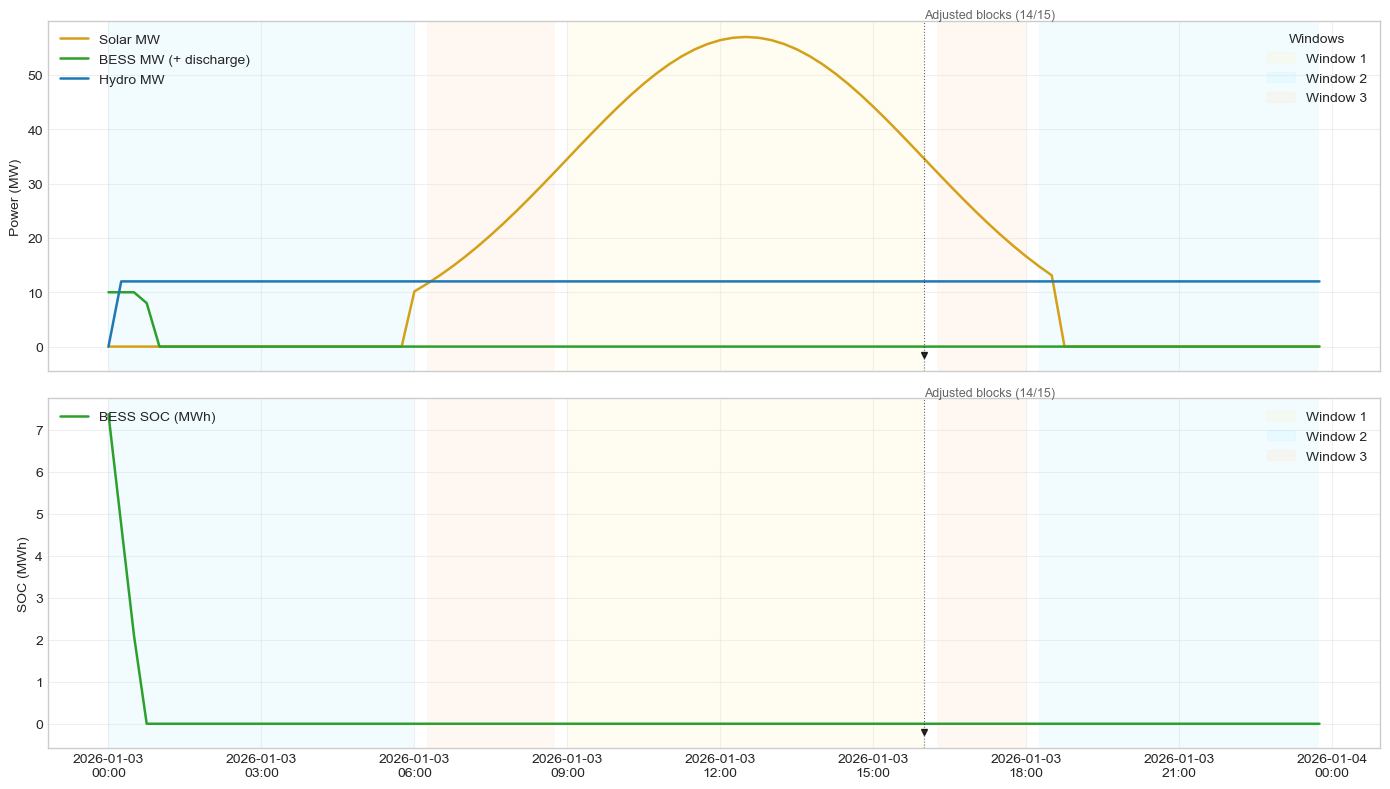

In [56]:
# Cell C: Power and SOC overview

def plot_power_and_soc(df, ts_col="ts_start"):
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # --- Power plot (MW)
    ax = axes[0]
    ax.plot(df[ts_col], df["solar_mw"], label="Solar MW", color=COLORS["solar"], linewidth=1.8)
    ax.plot(df[ts_col], df["p_bess_mw"], label="BESS MW (+ discharge)", color=COLORS["bess"], linewidth=1.8)
    ax.plot(df[ts_col], df["p_hydro_mw"], label="Hydro MW", color=COLORS["hydro"], linewidth=1.8)

    patches = shade_windows(ax, df)
    mark_adjusted_blocks(ax, df)

    ax.set_ylabel("Power (MW)")
    leg1 = ax.legend(loc="upper left")
    leg2 = ax.legend(handles=patches, loc="upper right", title="Windows")
    ax.add_artist(leg1)
    ax.grid(True, alpha=0.3)

    # --- SOC plot (MWh)
    ax2 = axes[1]
    if "soc_mwh" in df.columns and df["soc_mwh"].notna().any():
        ax2.plot(df[ts_col], df["soc_mwh"], label="BESS SOC (MWh)", color=COLORS["bess"], linewidth=1.8)
        patches2 = shade_windows(ax2, df)
        mark_adjusted_blocks(ax2, df)
        ax2.set_ylabel("SOC (MWh)")
        leg3 = ax2.legend(loc="upper left")
        leg4 = ax2.legend(handles=patches2, loc="upper right")
        ax2.add_artist(leg3)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, "BESS disabled (no SOC)", transform=ax2.transAxes, ha="center", va="center")
        ax2.set_axis_off()

    # time formatting
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
    plt.tight_layout()
    plt.show()

# Example call:
plot_power_and_soc(_rev_df)

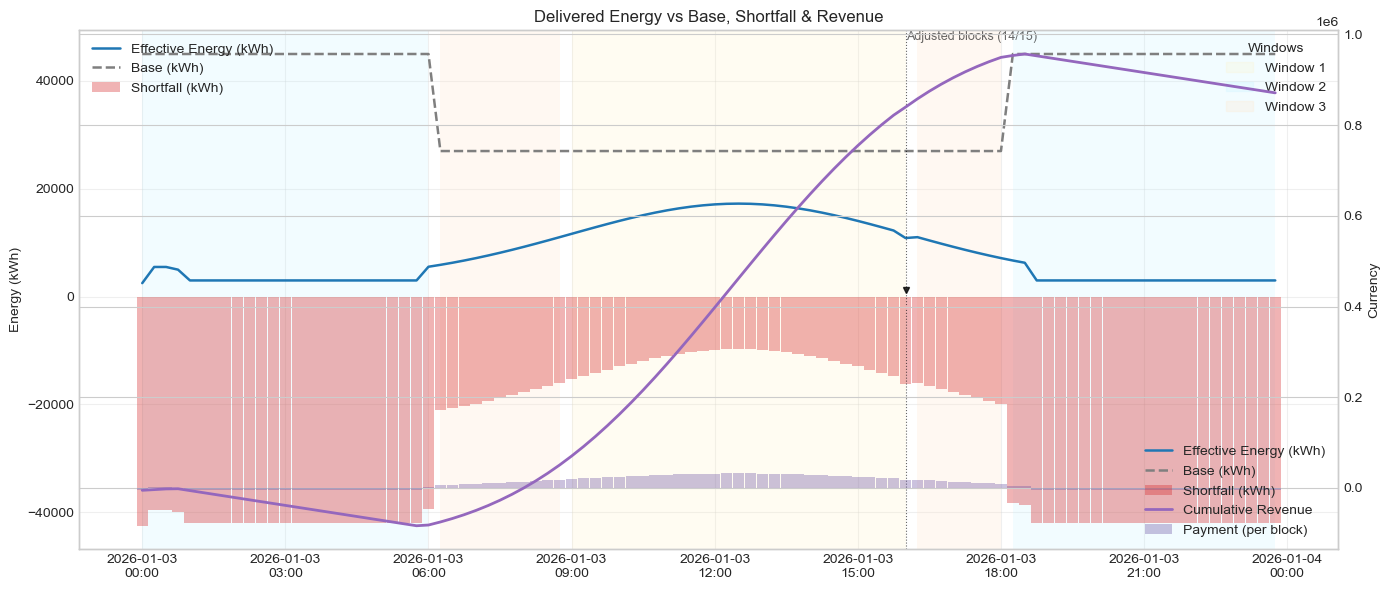

In [54]:
# Cell D: Energy delivered and base, with shortfall bars and payment overlay

def plot_energy_base_payment(df, ts_col="ts_start"):
    # Compute kWh per MW per 15-min (250 kWh)
    # If you used a different step, recompute accordingly.
    # Here we trust the metered energy already exists as 'e_use_kwh' from your revenue function.
    # 'base_kwh' is also provided by your function per window rules.  [1](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/objective_function.py)
    if "e_use_kwh" not in df.columns:
        # In some versions, objective_function uses 'e_use_kwh' name for adjusted energy,
        # otherwise your schedule had 'e_read_kwh'; try to find one.
        e_col = "e_read_kwh" if "e_read_kwh" in df.columns else None
    else:
        e_col = "e_use_kwh"

    if e_col is None:
        raise ValueError("Neither 'e_use_kwh' nor 'e_read_kwh' found in dataframe.")

    base_col = "base_kwh" if "base_kwh" in df.columns else None
    if base_col is None:
        raise ValueError("'base_kwh' column is required for this plot.")

    short_col = "shortfall_kwh" if "shortfall_kwh" in df.columns else None
    if short_col is None:
        raise ValueError("'shortfall_kwh' (from revenue calc) is required.")

    pay_col = "payment_currency" if "payment_currency" in df.columns else None
    if pay_col is None:
        raise ValueError("'payment_currency' column (from revenue calc) is required.")

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Lines for energy & base
    ax1.plot(df[ts_col], df[e_col], label="Effective Energy (kWh)", color=COLORS["hydro"], linewidth=1.8)
    ax1.plot(df[ts_col], df[base_col], label="Base (kWh)", color=COLORS["base"], linewidth=1.8, linestyle="--")

    patches = shade_windows(ax1, df)
    mark_adjusted_blocks(ax1, df)

    # Shortfall bars (downward)
    ax1.bar(df[ts_col], -df[short_col], width=0.01, color=COLORS["short"], alpha=0.35, label="Shortfall (kWh)")

    ax1.set_ylabel("Energy (kWh)")
    leg1 = ax1.legend(loc="upper left")
    leg2 = ax1.legend(handles=patches, loc="upper right", title="Windows")
    ax1.add_artist(leg1)
    ax1.grid(True, alpha=0.3)

    # Payment (per-block) on secondary axis
    ax2 = ax1.twinx()
    ax2.bar(df[ts_col], df[pay_col], width=0.01, color=COLORS["pay"], alpha=0.35, label="Payment (per block)")
    ax2.plot(df[ts_col], df[pay_col].cumsum(), color=COLORS["cum"], linewidth=2.0, label="Cumulative Revenue")
    ax2.set_ylabel("Currency")

    # Merge legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
    plt.title("Delivered Energy vs Base, Shortfall & Revenue")
    plt.tight_layout()
    plt.show()

# Example call:
plot_energy_base_payment(_rev_df)

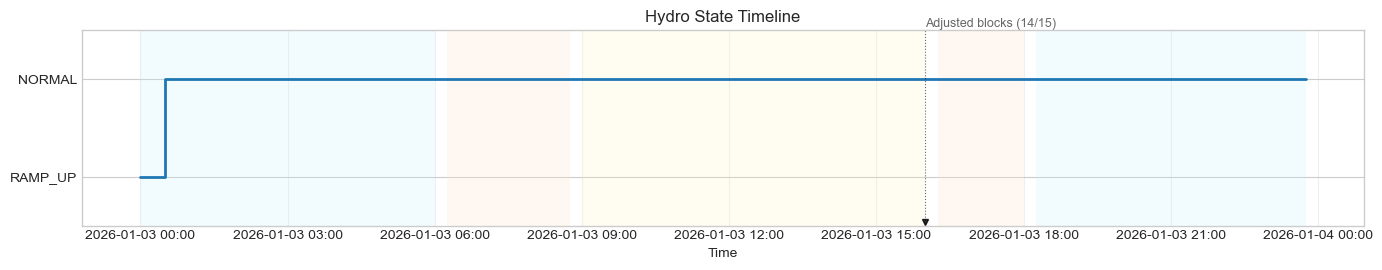

In [60]:
# Cell E: Hydro state timeline (START, RAMP_UP, NORMAL, RAMP_DOWN, SHUTDOWN)
# States come from your TurbineUnit five-state model.  [2](https://egatucc-my.sharepoint.com/personal/598584_egat_co_th/Documents/Microsoft%20Copilot%20Chat%20Files/FEB_turbine_unit_U1.py)

def plot_hydro_state(df, ts_col="ts_start", state_col="hydro_state"):
    if state_col not in df.columns:
        raise ValueError("hydro_state column not found.")

    # Map states to integers for plotting
    states = df[state_col].astype(str).unique().tolist()
    state_to_y = {s: i for i, s in enumerate(states)}
    y_vals = df[state_col].map(state_to_y)

    fig, ax = plt.subplots(figsize=(14, 2.8))
    ax.step(df[ts_col], y_vals, where="post", color=COLORS["hydro"], linewidth=2)

    # y ticks with state labels
    ax.set_yticks(list(state_to_y.values()), list(state_to_y.keys()))
    ax.set_ylim(-0.5, len(states)-0.5)

    patches = shade_windows(ax, df)
    mark_adjusted_blocks(ax, df)

    ax.set_title("Hydro State Timeline")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    ax.grid(True, axis="x", alpha=0.3)
    ax.set_xlabel("Time")
    plt.tight_layout()
    plt.show()

# Example call:
plot_hydro_state(_rev_df)

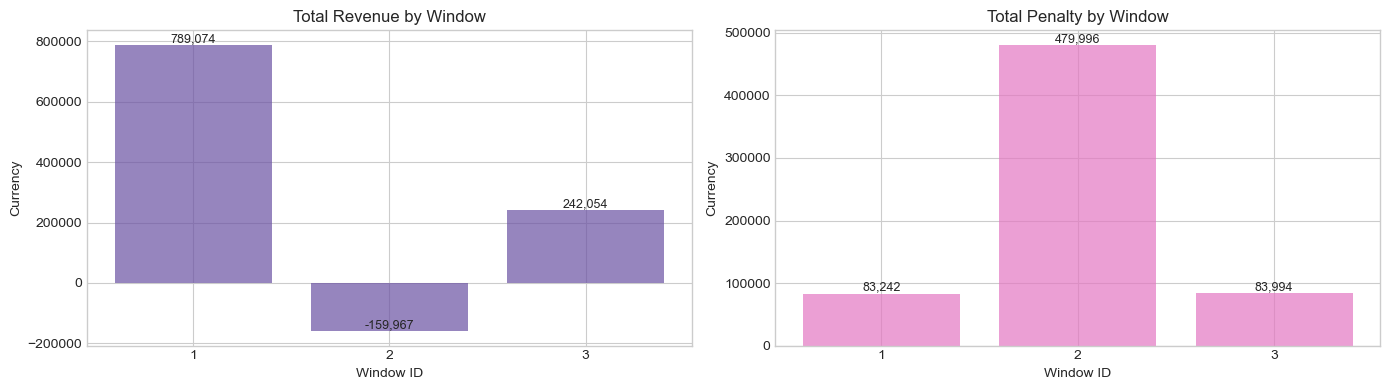

In [62]:
# Cell F: Aggregations — revenue by window and total penalties

def plot_revenue_breakdown(df):
    if "window_id" not in df.columns:
        raise ValueError("window_id column not found.")
    if "payment_currency" not in df.columns or "penalty_currency" not in df.columns:
        raise ValueError("'payment_currency' and 'penalty_currency' columns are required.")

    agg = df.groupby("window_id", as_index=False)[["payment_currency", "penalty_currency"]].sum()
    agg = agg.sort_values("window_id")

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))

    # Revenue by window
    ax[0].bar(agg["window_id"].astype(str), agg["payment_currency"], color=COLORS["pay"], alpha=0.7)
    ax[0].set_title("Total Revenue by Window")
    ax[0].set_xlabel("Window ID")
    ax[0].set_ylabel("Currency")
    for i, v in enumerate(agg["payment_currency"]):
        ax[0].text(i, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

    # Total penalties by window
    ax[1].bar(agg["window_id"].astype(str), agg["penalty_currency"], color=COLORS["pen"], alpha=0.7)
    ax[1].set_title("Total Penalty by Window")
    ax[1].set_xlabel("Window ID")
    ax[1].set_ylabel("Currency")
    for i, v in enumerate(agg["penalty_currency"]):
        ax[1].text(i, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

# Example call:
plot_revenue_breakdown(_rev_df)

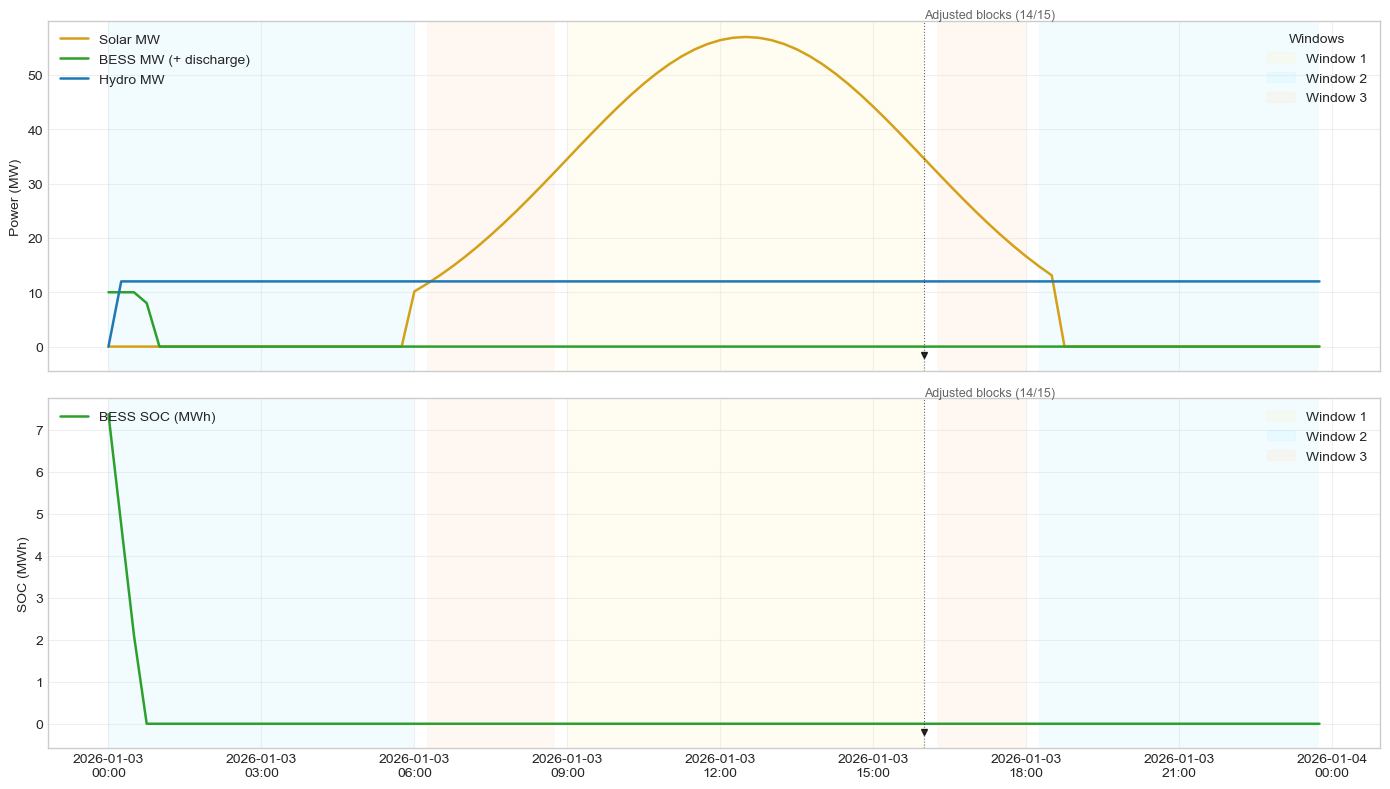

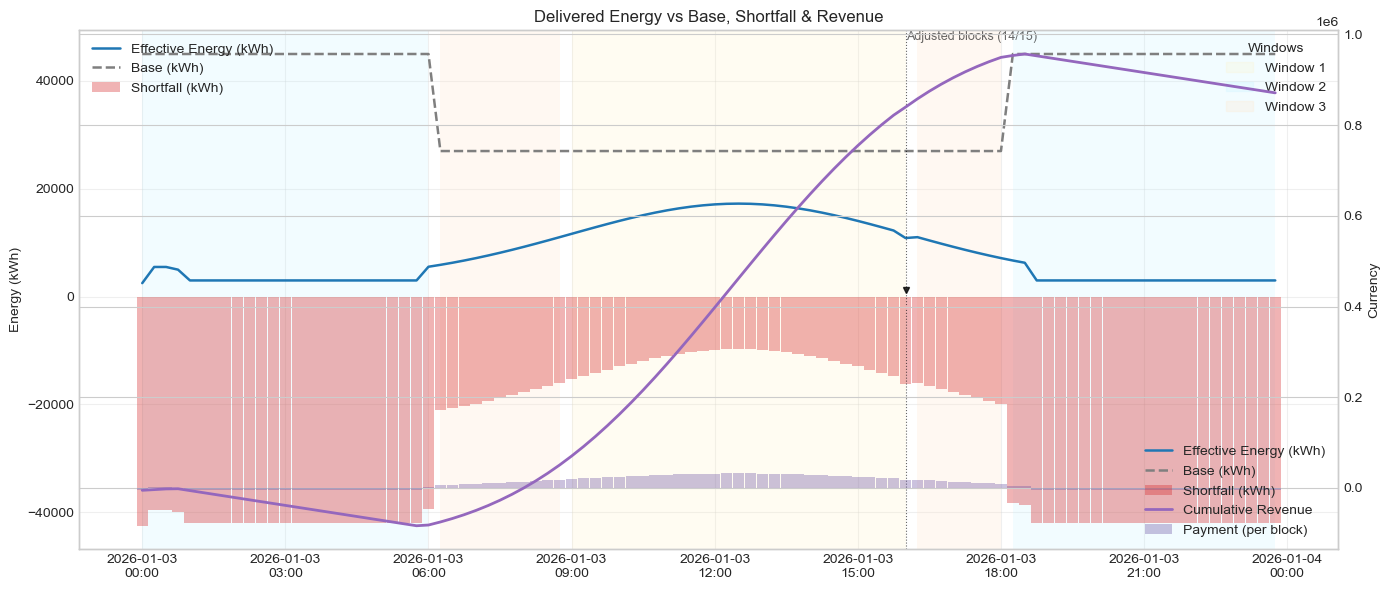

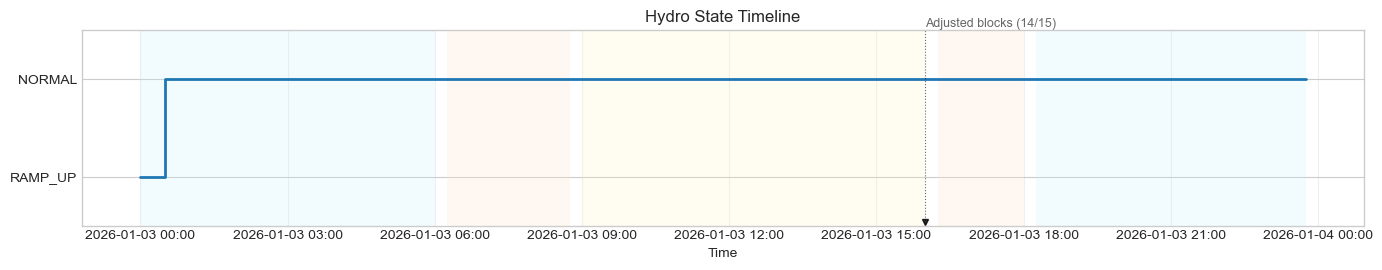

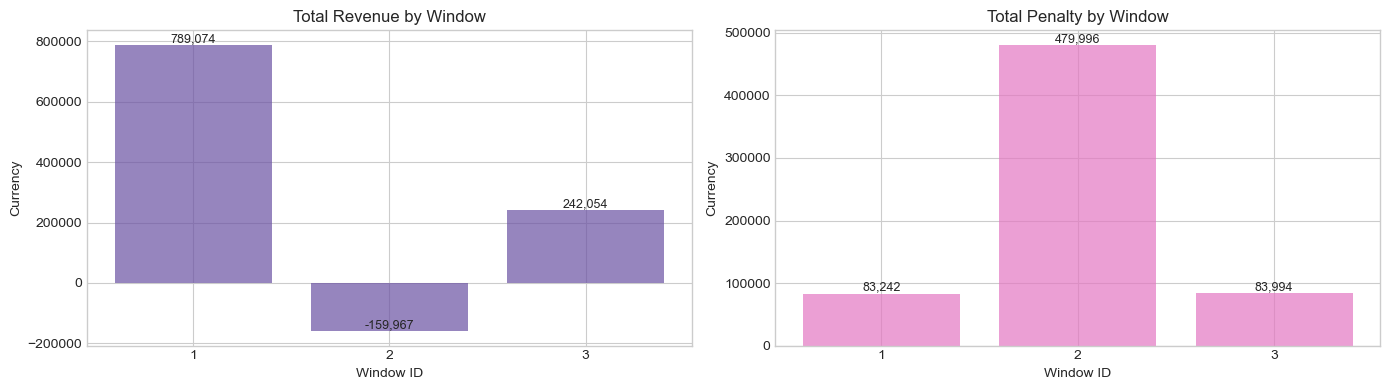

In [64]:
# Cell G: Quick dashboard — run these after you computed _rev_df

plot_power_and_soc(_rev_df)
plot_energy_base_payment(_rev_df)
plot_hydro_state(_rev_df)
plot_revenue_breakdown(_rev_df)